<a href="https://colab.research.google.com/github/skybrian/boing_ball_animation/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageColor, ImageSequence, ImageFile
from types import SimpleNamespace
import math
import inspect
import json
import IPython
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
params = SimpleNamespace()
params.square_size = 15
params.checkerboard_colors = ['red', 'white']
params.ball_radius = 100
params.width = 640
params.height = 480
params.margin = 40
params.vertical_grid_lines = 10
params.ball_height = 200
params.animation_length = 5
params.bounces = 4
params.ball_tilt = -20
params.shadow_opacity = 0.5
params.shadow_x_offset = 50
params.spins_per_second = -0.2
params.frames_per_second = 30

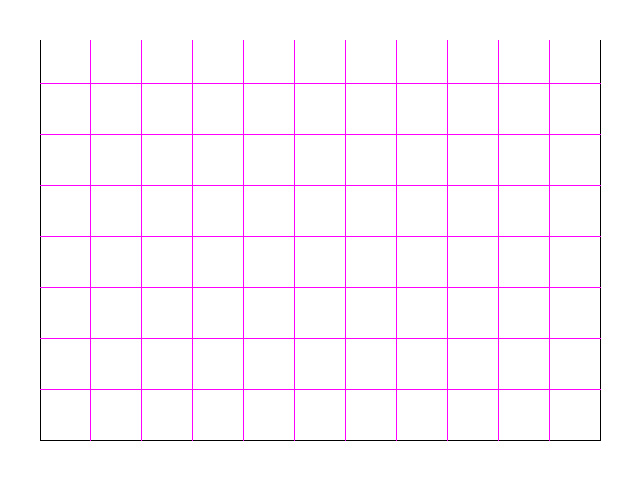

In [3]:
def make_background_image():
    # Create a white RGBA image
    image = Image.new('RGBA', (params.width, params.height), 'white')

    # Create a draw object
    draw = ImageDraw.Draw(image)

    # Draw the walls and floor
    draw.line([(params.margin, params.margin), (params.margin, params.height - params.margin)], 'black')
    draw.line([(params.margin, params.height - params.margin), (params.width - params.margin, params.height - params.margin)], 'black')
    draw.line([(params.width - params.margin, params.margin), (params.width - params.margin, params.height - params.margin)], 'black')

    # Draw the grid lines
    for i in range(params.vertical_grid_lines):
        x = params.margin + (params.width - 2 * params.margin) * (i + 1) / (params.vertical_grid_lines + 1)
        draw.line([(x, params.margin), (x, params.height - params.margin)], 'magenta')

    spacing = (params.width - 2 * params.margin) / (params.vertical_grid_lines + 1)
    y = params.height - params.margin - spacing
    while y > params.margin:
        draw.line([(params.margin, y), (params.width - params.margin, y)], 'magenta')
        y -= spacing

    return image


image = make_background_image()
image.show()

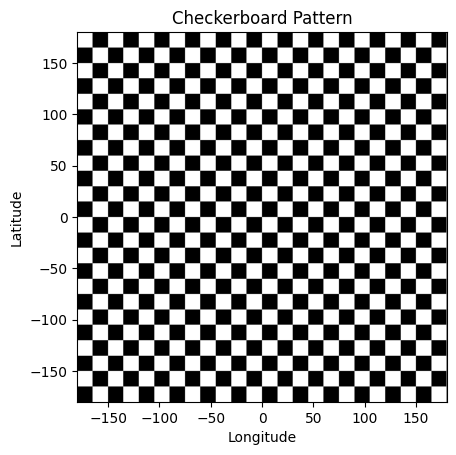

In [4]:
def checkerboard(latitudes, longitudes):
    # Convert degrees to radians as numpy trig functions expect radians
    latitudes_rad = np.deg2rad(latitudes)
    longitudes_rad = np.deg2rad(longitudes)

    # Convert latitudes and longitudes to a square size scale
    latitudes_scaled = np.floor(latitudes_rad / np.deg2rad(params.square_size))
    longitudes_scaled = np.floor(longitudes_rad / np.deg2rad(params.square_size))

    # Create the checkerboard pattern
    return (latitudes_scaled + longitudes_scaled) % 2


# Create a grid of latitudes and longitudes
latitudes, longitudes = np.meshgrid(np.linspace(-180, 180, 1000), np.linspace(-180, 180, 1000))

# Apply the checkerboard function
pattern = checkerboard(latitudes, longitudes)

# Visualize the pattern
plt.imshow(pattern, cmap='gray', origin='lower', extent=[-180, 180, -180, 180])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Checkerboard Pattern')
plt.show()

In [5]:
def get_checkerboard_colors():
    # Create an array to store the RGB values
    rgba_colors = []

    # For each color in params.checkerboard_colors, convert it to RGB and append it to the array
    for color in params.checkerboard_colors:
        rgba_colors.append(list(ImageColor.getcolor(color, "RGBA")))

    return np.array(rgba_colors, dtype=np.uint8)


rgba_colors = get_checkerboard_colors()
print(rgba_colors)
img = Image.new("RGBA", (40, 20))
for i, color in enumerate(rgba_colors):
    square = Image.new("RGBA", (20, 20), tuple(color))
    img.paste(square, (i*20, 0))
img.show()

[[255   0   0 255]
 [255 255 255 255]]


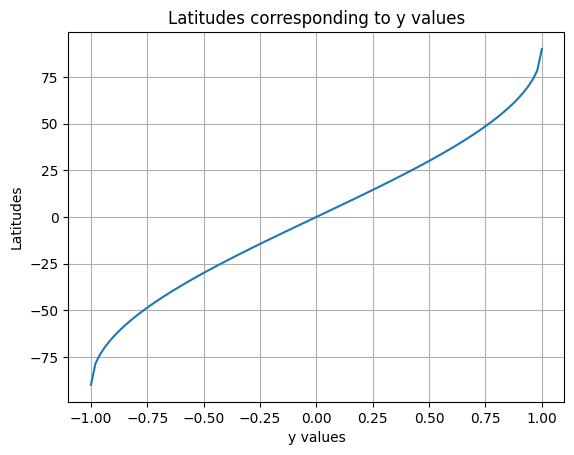

In [6]:
def latitude(y):
    # Convert y coordinates on the unit sphere to latitudes
    # Latitude is the arcsin of y, converted from radians to degrees
    return np.rad2deg(np.arcsin(y))


import matplotlib.pyplot as plt
y_values = np.linspace(-1, 1, 100)
latitudes = latitude(y_values)
plt.plot(y_values, latitudes)
plt.xlabel('y values')
plt.ylabel('Latitudes')
plt.title('Latitudes corresponding to y values')
plt.grid(True)
plt.show()

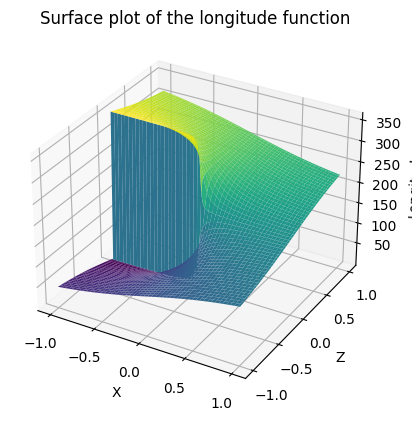

In [7]:
def longitude(x, z):
    # Compute longitude from x and z coordinates on the unit sphere
    # Longitude is the arctan of x/z, converted from radians to degrees
    # And then shifted and scaled to be in the range [0, 360]
    longitude_rad = np.arctan2(z, x)  # Swap x and z to match standard geographical definition
    return (np.rad2deg(longitude_rad) + 180) % 360


# Create a grid of x and z values
x_values = np.linspace(-1, 1, 100)
z_values = np.linspace(-1, 1, 100)
x, z = np.meshgrid(x_values, z_values)

# Compute the longitude for each (x, z) pair
longitudes = longitude(x, z)

# Create a new figure and an axes for the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, z, longitudes, cmap='viridis')

# Set the labels and title
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Longitude')
ax.set_title('Surface plot of the longitude function')

# Show the plot
plt.show()

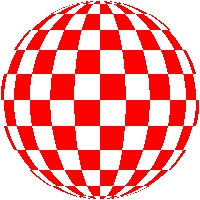

In [8]:
def ball_colors(x, y, spin=0):
    # Compute z^2
    z_sq = 1 - x**2 - y**2

    # Initialize an empty array for the colors
    colors = np.zeros((*x.shape, 4))

    # Only compute colors for points on the sphere (where z^2 is non-negative)
    on_sphere = z_sq >= 0
    z = np.sqrt(z_sq[on_sphere])

    # Compute the latitudes and longitudes for the points on the sphere
    latitudes = latitude(y[on_sphere])
    longitudes = (longitude(x[on_sphere], z) + spin) % 360  # Add the spin to the longitude

    # Compute the checkerboard pattern and convert it to integer type
    pattern = checkerboard(latitudes, longitudes).astype(int)

    # Assign colors based on the pattern
    colors[on_sphere] = get_checkerboard_colors()[pattern]

    return colors.astype(np.uint8)


x, y = np.meshgrid(np.linspace(-1, 1, 2*params.ball_radius), np.linspace(-1, 1, 2*params.ball_radius))
colors = ball_colors(x, y)
image = Image.fromarray(colors, 'RGBA')
image.show()

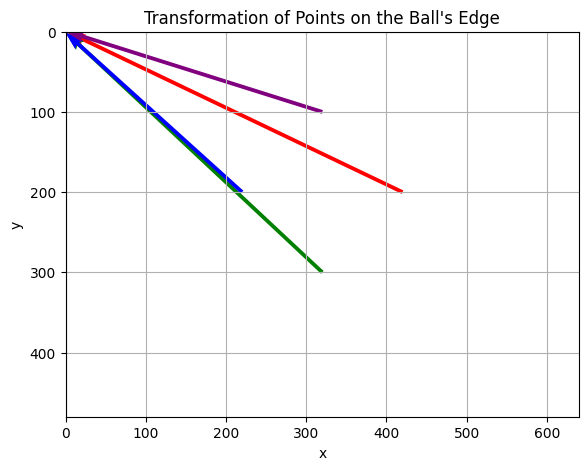

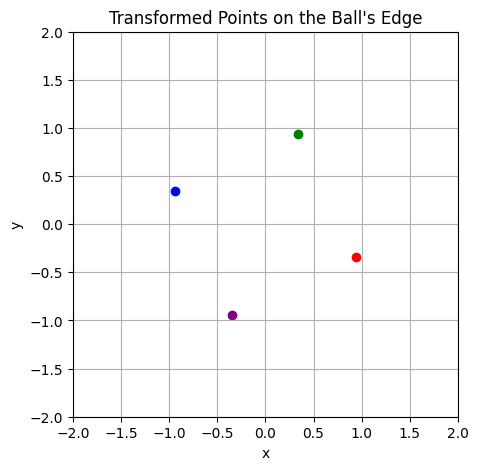

In [9]:
def ball_coordinates(width, height, x_center, y_center):
    # Create a grid of x and y coordinates for the image
    x_image, y_image = np.meshgrid(np.arange(width), np.arange(height))

    # Convert these to coordinates on the unit sphere
    x_ball = (x_image - x_center) / params.ball_radius
    y_ball = (y_image - y_center) / params.ball_radius

    # Apply the tilt to the coordinates
    tilt_rad = np.deg2rad(params.ball_tilt)
    x_tilted = x_ball * np.cos(tilt_rad) - y_ball * np.sin(tilt_rad)
    y_tilted = x_ball * np.sin(tilt_rad) + y_ball * np.cos(tilt_rad)

    return x_tilted, y_tilted

# Select 4 points along the circumference of the ball
theta = np.linspace(0, 2*np.pi, 5)[:-1]  # angles to generate points
x_center = 320
y_center = 200
x_ball_edge = params.ball_radius * np.cos(theta) + x_center
y_ball_edge = params.ball_radius * np.sin(theta) + y_center

# Transform the points
x_transformed, y_transformed = ball_coordinates(params.width, params.height, x_center, y_center)
x_transformed_edge = x_transformed[y_ball_edge.astype(int), x_ball_edge.astype(int)]
y_transformed_edge = y_transformed[y_ball_edge.astype(int), x_ball_edge.astype(int)]

# Define colors for the arrows/points
colors = ['red', 'green', 'blue', 'purple']

# Create the quiver plot for the transformation with different colors
plt.figure(figsize=(8,5))
for i in range(4):
    plt.quiver(x_ball_edge[i], y_ball_edge[i], x_transformed_edge[i]-x_ball_edge[i], y_transformed_edge[i]-y_ball_edge[i],
               color=colors[i], angles='xy', scale_units='xy', scale=1)
plt.xlim(0, params.width)
plt.ylim(params.height, 0)  # invert the y-axis to match image coordinate system
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Transformation of Points on the Ball's Edge")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# Create the plot for the transformed points with corresponding colors
plt.figure(figsize=(8,5))
for i in range(4):
    plt.scatter(x_transformed_edge[i], y_transformed_edge[i], color=colors[i])
plt.xlim(-2, 2)  # set limits to show unit circle
plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Transformed Points on the Ball's Edge")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

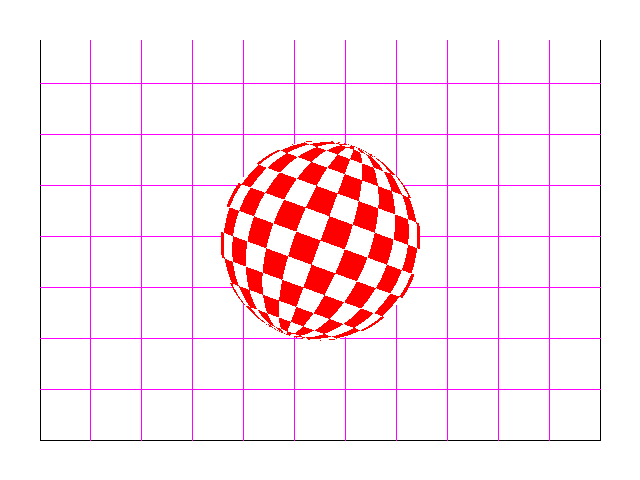

In [10]:
def draw_ball(image, x, y, spin):
    # Calculate the coordinates for the ball
    X, Y = ball_coordinates(image.width, image.height, x, y)

    # Compute the colors for the ball
    colors = ball_colors(X, Y, spin)

    # Create a Pillow image for the ball
    ball_image = Image.fromarray(colors, 'RGBA')

    # Composite the ball into the image
    image.alpha_composite(ball_image, (0, 0))


image = make_background_image()
draw_ball(image, params.width // 2, params.height // 2, 0)
image.show()

In [11]:
def calculate_g():
    # Calculate the time to fall
    time_to_fall = params.animation_length / (2 * params.bounces)

    # Use the equation of motion to calculate g
    # h = 0.5 * g * t^2  =>  g = 2h / t^2
    g = 2 * params.ball_height / time_to_fall**2

    return g


print(calculate_g())

1024.0


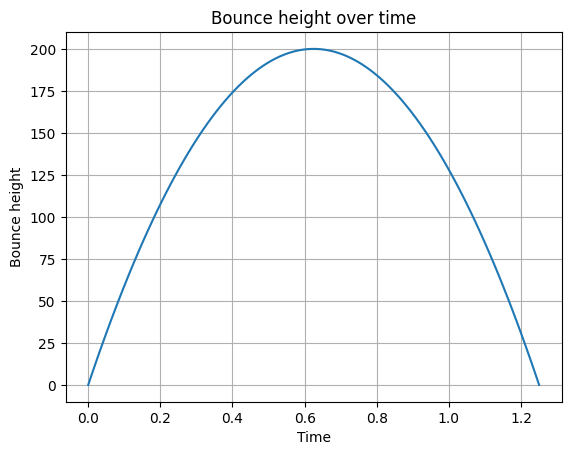

In [12]:
def bounce_height(t):
    # Calculate the acceleration due to gravity
    g = calculate_g()

    # Calculate the initial velocity
    v_i = np.sqrt(2 * params.ball_height * g)

    # Calculate the height as a function of time
    h = v_i * t - 0.5 * g * t**2

    # Ensure the height is zero after the ball has fallen
    h = np.maximum(h, 0)

    return h


times = np.linspace(0, params.animation_length / params.bounces, 100)
heights = bounce_height(times)
plt.plot(times, heights)
plt.xlabel('Time')
plt.ylabel('Bounce height')
plt.title('Bounce height over time')
plt.grid(True)
plt.show()

In [13]:
def bounce_times():
    # Calculate the duration of each bounce
    bounce_duration = params.animation_length / params.bounces

    # Calculate the start times for each bounce
    times = np.arange(-bounce_duration / 2, params.animation_length, bounce_duration)

    return times


print(bounce_times())

[-0.625  0.625  1.875  3.125  4.375]


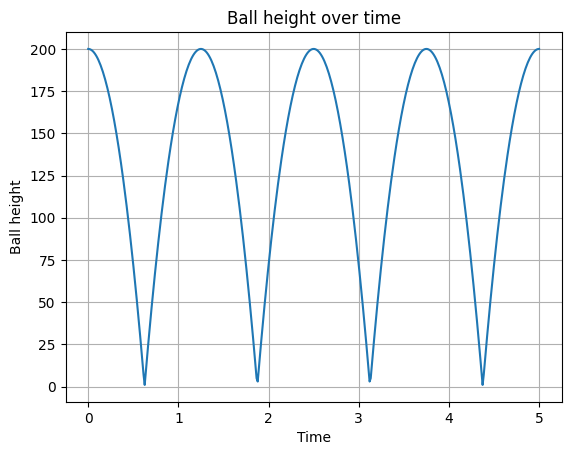

In [14]:
def ball_height(t):
    # Get the bounce times
    bounce_start_times = bounce_times()

    # Create an empty array to store the heights
    height = np.empty_like(t)

    # For each time, find the start of the most recent bounce and calculate the height
    for i, time in np.ndenumerate(t):
        # Find the start time of the most recent bounce
        bounce_start = bounce_start_times[bounce_start_times <= time][-1]

        # Calculate the time since the start of the bounce
        t_since_bounce = time - bounce_start

        # Calculate the height of the ball
        height[i] = bounce_height(t_since_bounce)

    return height


times = np.linspace(0, params.animation_length, 400)
heights = ball_height(times)
plt.plot(times, heights)
plt.xlabel('Time')
plt.ylabel('Ball height')
plt.title('Ball height over time')
plt.grid(True)
plt.show()

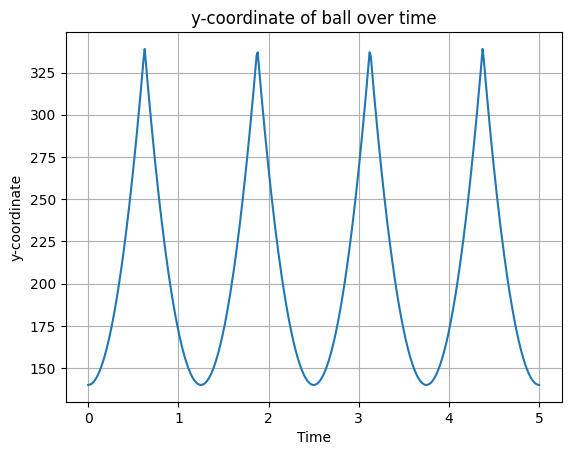

In [15]:
def simulate_y(t):
    # Calculate the height of the ball
    height = ball_height(t)

    # Convert this to the y-coordinate of the ball's center
    y = params.height - params.margin - height - params.ball_radius

    return y


times = np.linspace(0, params.animation_length, 400)
y_values = simulate_y(times)
plt.plot(times, y_values)
plt.xlabel('Time')
plt.ylabel('y-coordinate')
plt.title('y-coordinate of ball over time')
plt.grid(True)
plt.show()

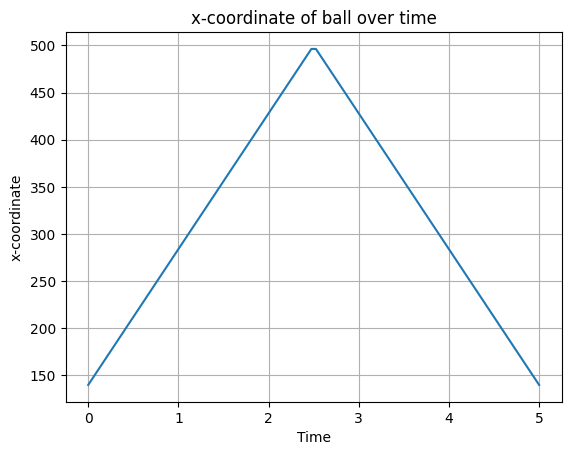

In [16]:
def simulate_x(t):
    # Calculate the position of the ball
    x = np.empty_like(t, dtype=float)
    t = np.asarray(t)

    # For the first half of the animation, the ball moves from the left wall to the right wall
    mask = t < params.animation_length / 2
    x[mask] = params.margin + params.ball_radius + t[mask] * (params.width - 2 * (params.margin + params.ball_radius)) / (params.animation_length / 2)

    # For the second half of the animation, the ball moves from the right wall back to the left wall
    mask = ~mask
    x[mask] = params.width - params.margin - params.ball_radius - (t[mask] - params.animation_length / 2) * (params.width - 2 * (params.margin + params.ball_radius)) / (params.animation_length / 2)

    return x


times = np.linspace(0, params.animation_length, 100)
x_values = simulate_x(times)
plt.plot(times, x_values)
plt.xlabel('Time')
plt.ylabel('x-coordinate')
plt.title('x-coordinate of ball over time')
plt.grid(True)
plt.show()

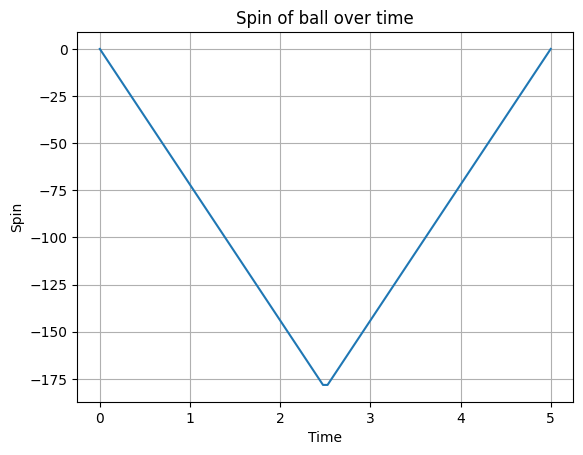

In [17]:
def simulate_spin(t):
    # Calculate the spin of the ball
    spin = np.empty_like(t, dtype=float)
    t = np.asarray(t)

    # For the first half of the animation, the ball spins in one direction
    mask = t < params.animation_length / 2
    spin[mask] = t[mask] * params.spins_per_second * 360

    # For the second half of the animation, the ball spins in the opposite direction
    mask = ~mask
    spin[mask] = (params.animation_length - t[mask]) * params.spins_per_second * 360

    return spin


times = np.linspace(0, params.animation_length, 100)
spin_values = simulate_spin(times)
plt.plot(times, spin_values)
plt.xlabel('Time')
plt.ylabel('Spin')
plt.title('Spin of ball over time')
plt.grid(True)
plt.show()

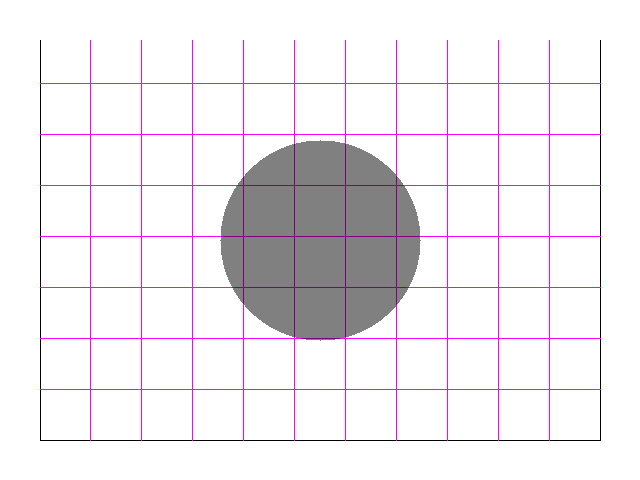

In [18]:
def draw_shadow(image, x, y):
    # Calculate the coordinates for the shadow
    X, Y = ball_coordinates(image.width, image.height, x, y)

    # Calculate the distances squared from the center
    D_sq = X**2 + Y**2

    # Create a mask for the pixels that are inside the circle
    mask = D_sq <= 1

    # Create an array for the RGBA values of the shadow
    shadow_pixels = np.zeros((*X.shape, 4), dtype=np.uint8)
    shadow_pixels[..., 3] = (mask * 255 * params.shadow_opacity).astype(np.uint8)

    # Clear pixels to the right of the wall
    shadow_pixels[:, int(params.width - params.margin):] = 0

    # Create a Pillow image for the shadow
    shadow_image = Image.fromarray(shadow_pixels, 'RGBA')

    # Composite the shadow into the image
    image.alpha_composite(shadow_image, (0, 0))


image = make_background_image()
draw_shadow(image, params.width // 2, params.height // 2)
image.show()

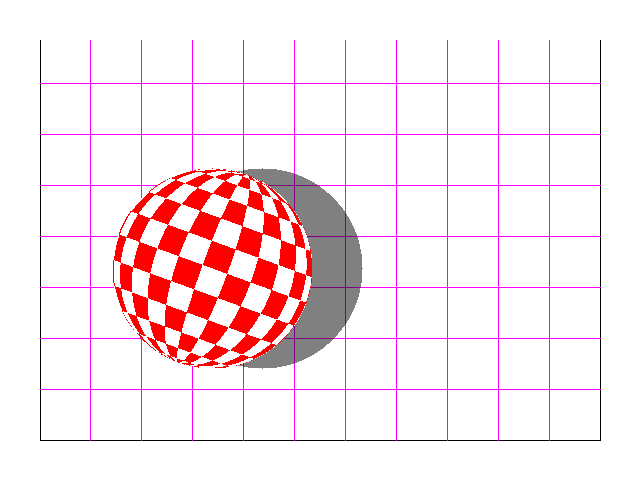

In [19]:
def draw_frame(t):
    # Create the background image
    image = make_background_image()

    # Calculate the x, y and spin for the current time
    x = simulate_x(t)
    y = simulate_y(t)
    spin = simulate_spin(t)

    # Draw the shadow
    draw_shadow(image, x + params.shadow_x_offset, y)

    # Draw the ball
    draw_ball(image, x, y, spin)

    return image


frame = draw_frame(0.5)
frame.show()

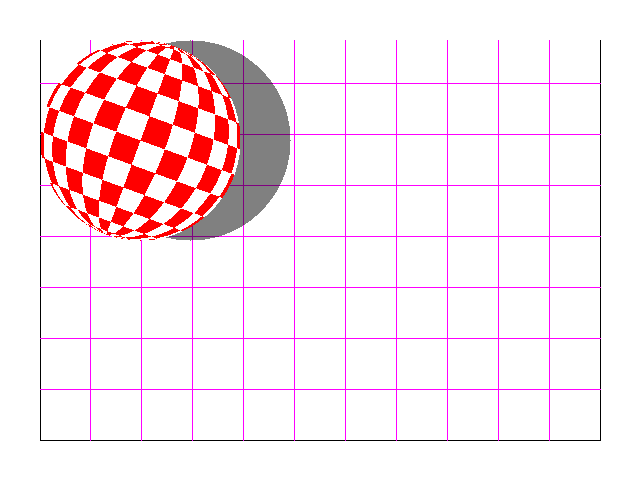

In [20]:
def draw_animation():
    # Create a list to store the frames
    frames = []

    # Calculate the total number of frames
    total_frames = int(params.animation_length * params.frames_per_second)

    # Draw each frame
    for i in range(total_frames):
        # Calculate the time for this frame
        t = i / params.frames_per_second

        # Draw the frame
        frame = draw_frame(t)

        # Add the frame to the list
        frames.append(frame)

    # Save the frames as an animated GIF
    frames[0].save("animation.gif", save_all=True, append_images=frames[1:], optimize=False, duration=40, loop=0)


draw_animation()
IPython.display.Image(filename="animation.gif")